In [1]:
#Module configuration
#from py2neo import Graph #Database connection
import neomodel
import pandas as pd
import datetime
import numpy as np
import torch
import torch.nn as nn
import random
import os

In [2]:
#Config
# Parameters :

#Structuration of the acte in the graph database -> See directly in the cell
#Nb of Embedings dimensions in Node2vec:
#embeddingNbDimensions=3

def embeddingNbDimensions():
    #NbDim=3
    NbDim=nb_dimensions
    return NbDim


#Size of the Carepath extraction
def size_of_CP_to_learn(Maxlength):
    #size = Maxlength
    size = max(int(Maxlength),2)
    #size = 100
    return size


showelbow=False
optimal_clusters=6
nb_vocab =optimal_clusters

lstm_size=128
embedding_dim = 20
n_hidden = 30
lr=0.05
criterion = nn.MSELoss()  # Suitable loss function

#nn.NLLLoss()  nn.CrossEntropyLoss() nn.MSELoss()

myFileName='DataCP_Example/CP_Category_1.csv'
#'DataCP_Example/CP_Category_1.csv'
#DL_Project_Dataset_Sample_V5.csv
#'Dataset_Simple_V0.csv'
#'DL_Project_Dataset_LongCP_Cluster1-772Patients.csv'
renew_database=True


In [3]:
from neomodel import config

neo4jServerAdress = "172.21.56.47"
neo4jConnectionPort = 7687  #Connection to server bolt
user= "neo4j" 
password= "Mypassword%2023"
config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

In [4]:
from neomodel import (config, StructuredNode, StringProperty, IntegerProperty,DateTimeProperty,
                    DateTimeFormatProperty,UniqueIdProperty, RelationshipTo,StructuredRel)

config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

#NIP	J_Parcours	DateDebutActe	DateFinActe	UF	Service	Phase_Parcours	Activite	Dimension_Parcours	Ref_Acte	id_Sequence	Type_Sequence	id_sejour

class FOLLOWED_BY(StructuredRel):
    #Nb_Days = IntegerProperty(index=True, default=0)
    Next_Acte_from_JP = IntegerProperty(index=True, default=0)
    NIP=StringProperty(required=False)

class Acte(StructuredNode):
    Ref_Acte = StringProperty(required=True)
    #J_Parcours=IntegerProperty(required=False)
    #Duree = IntegerProperty(required=False)
    UF = StringProperty(required=True)
    #Service = StringProperty(required=True)
    #Phase_Parcours =StringProperty(required=True)
    #Activite =StringProperty(required=True)
    #Dimension_Parcours = StringProperty(required=True)
    #Nombre_actes=IntegerProperty(required=False, default=1)     
    Carepath = RelationshipTo('Acte', 'FOLLOWED_BY', model=FOLLOWED_BY)

class Patient(StructuredNode):
    NIP = StringProperty(unique_index=True, required=True)
    J0 = StringProperty(required=True)
    J_Parcours = IntegerProperty(required=False, default=0)
    Carepath = RelationshipTo('Acte', 'BEGIN_CAREPATH_WITH', model=FOLLOWED_BY)

In [5]:
# Define the filepath of the import csvfile
file_path = os.path.join('..', '01_Datasets', myFileName)
#file_path = r'..\01_Datasets\{myFileName}'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';')
# Display the first few rows of the DataFrame
df

,NIP,J_Parcours,DateDebutActe,DateFinActe,UF,Service,Phase_Parcours,Activite,Dimension_Parcours,Ref_Acte,id_Sequence,Type_Sequence,id_sejour
0,NIP1,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,80,Med,Ph1,Ac1,Dim1,Ref1,Seq1,TSEQ1,IDSej1
1,NIP1,2,2019-01-04 00:00:00.000,2019-01-04 00:00:00.000,81,Med,Ph2,Ac2,Dim2,Ref2,Seq2,TSEQ2,IDSej2
2,NIP1,4,2019-01-06 00:00:00.000,2019-01-06 00:00:00.000,82,Med,Ph3,Ac3,Dim3,Ref3,Seq3,TSEQ3,IDSej3
3,NIP1,6,2019-01-08 00:00:00.000,2019-01-08 00:00:00.000,83,Med,Ph4,Ac4,Dim4,Ref4,Seq4,TSEQ4,IDSej4
4,NIP1,8,2019-01-10 00:00:00.000,2019-01-10 00:00:00.000,84,Med,Ph5,Ac5,Dim5,Ref5,Seq5,TSEQ5,IDSej5
5,NIP1,10,2019-01-12 00:00:00.000,2019-01-12 00:00:00.000,85,Med,Ph6,Ac6,Dim6,Ref6,Seq6,TSEQ6,IDSej6
6,NIP2,0,2019-02-02 00:00:00.000,2019-02-02 00:00:00.000,80,Med,Ph1,Ac1,Dim1,Ref1,Seq1,TSEQ1,IDSej7
7,NIP2,2,2019-02-04 00:00:00.000,2019-02-04 00:00:00.000,81,Med,Ph2,Ac2,Dim2,Ref2,Seq2,TSEQ2,IDSej8
8,NIP2,4,2019-02-06 00:00:00.000,2019-02-06 00:00:00.000,82,Med,Ph3,Ac3,Dim3,Ref3,Seq3,TSEQ3,IDSej9
9,NIP2,6,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,83,Med,Ph4,Ac4,Dim4,Ref4,Seq4,TSEQ4,IDSej10


Ref_Acte
Ref1    0.166667
Ref2    0.166667
Ref3    0.166667
Ref4    0.166667
Ref5    0.166667
Ref6    0.166667
Name: proportion, dtype: float64


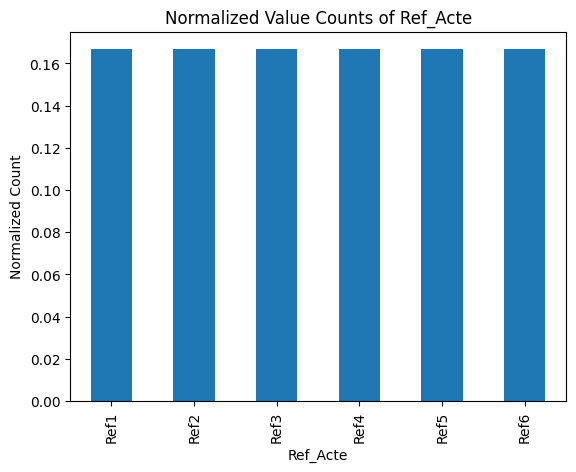

Ref_Acte
Ref1    0.166667
Ref2    0.166667
Ref3    0.166667
Ref4    0.166667
Ref5    0.166667
Name: proportion, dtype: float64


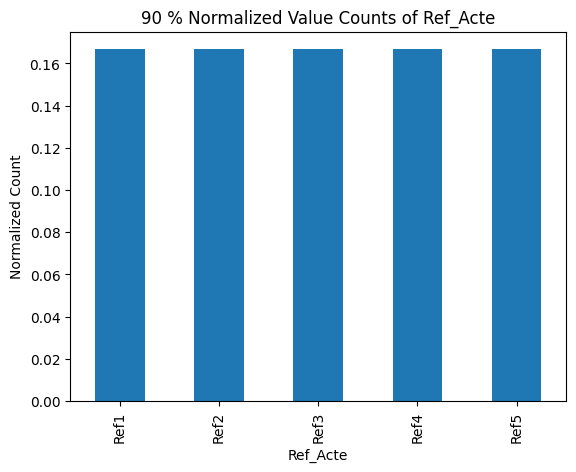

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


cut= 90
#DATA ANALYSIS / FILTERING
Actes_summary_normalized = df['Ref_Acte'].value_counts(normalize=True)
print(Actes_summary_normalized)

# Plot the normalized value counts
Actes_summary_normalized.plot(kind='bar')
plt.title('Normalized Value Counts of Ref_Acte')
plt.xlabel('Ref_Acte')
plt.ylabel('Normalized Count')
plt.show()

# Calculate the cumulative sum of normalized value counts
cumulative_sum = Actes_summary_normalized.cumsum()
# Filter 'Ref_Acte' values that contribute to the top 90% of occurrences
top_90_percent = Actes_summary_normalized[cumulative_sum <= cut/100]
# Display the filtered 'Ref_Acte' values
print(top_90_percent)

# Plot the normalized value counts
top_90_percent.plot(kind='bar')
plt.title(f'{cut} % Normalized Value Counts of Ref_Acte')
plt.xlabel('Ref_Acte')
plt.ylabel('Normalized Count')
plt.show()



In [7]:
# One-hot encode 'UF' and 'Ref_Acte' columns
uf_encoded = pd.get_dummies(df['UF'], prefix='UF')
ref_acte_encoded = pd.get_dummies(df['Ref_Acte'], prefix='Ref_Acte')

# Concatenate 'id_sejour' column with one-hot encoded columns
result=pd.concat([df['id_sejour'], ref_acte_encoded], axis=1)
#result = pd.concat([df['id_sejour'], uf_encoded, ref_acte_encoded], axis=1)

# Group by 'id_sejour' and sum the one-hot encoded columns
result_grouped = result.groupby('id_sejour').sum().reset_index()
print(result_grouped)

   id_sejour  Ref_Acte_Ref1  Ref_Acte_Ref2  Ref_Acte_Ref3  Ref_Acte_Ref4  \
0     IDSej1              2              0              0              0   
1    IDSej10              0              0              0              2   
2    IDSej11              0              0              0              0   
3    IDSej12              0              0              0              0   
4    IDSej13              2              0              0              0   
5    IDSej14              0              2              0              0   
6    IDSej15              0              0              2              0   
7    IDSej16              0              0              0              2   
8    IDSej17              0              0              0              0   
9    IDSej18              0              0              0              0   
10   IDSej19              2              0              0              0   
11    IDSej2              0              2              0              0   
12   IDSej20

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Remove 'id_sejour' if it's not numerical
data = result_grouped.drop('id_sejour', axis=1)

if showelbow:

    #Nb_max of clusters
    nb_max=100

    # Find optimal number of clusters using Elbow Method
    wcss = []
    for i in range(1, nb_max):  # Trying up to 20 clusters
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, nb_max), wcss, marker='o', linestyle='-')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.xticks(np.arange(1, 21, 1))
    plt.grid(True)
    plt.show()


In [9]:
if showelbow:
    # From the plot, choose the optimal number of clusters
    optimal_clusters = int(nb_max/3)  # Example, choose based on the plot
    optimal_clusters

c:\Anaconda\envs\DL_Project2\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


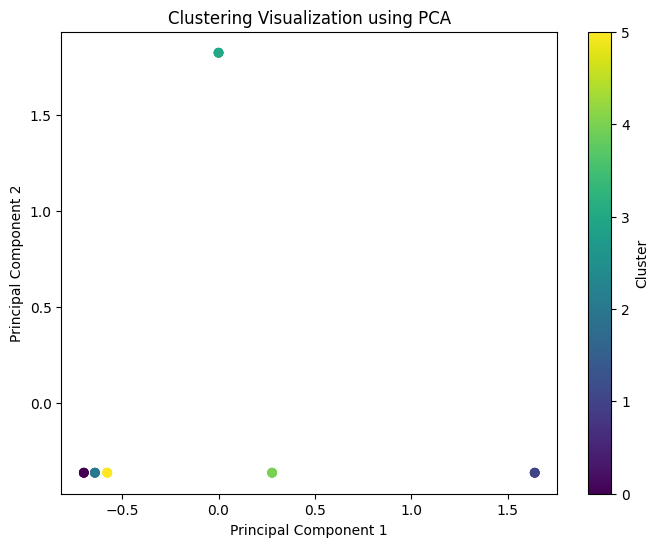

In [10]:
#Choose the nb of cluster to be created
#nb_vocab 

from sklearn.mixture import GaussianMixture

# Create a Gaussian Mixture Model with the optimal number of components
gmm = GaussianMixture(n_components=nb_vocab, random_state=42)
# Fit the GMM to the data
gmm.fit(data)
clusters = gmm.predict(data)

# Perform KMeans clustering with optimal number of clusters
#kmeans = KMeans(n_clusters=nb_dimensions, random_state=42)
#clusters = kmeans.fit_predict(data)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Visualize the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Visualization using PCA')
plt.colorbar(label='Cluster')
plt.show()

In [11]:
# Add cluster labels to the original dataframe
data['Cluster'] = clusters

# Calculate mean of each cluster's individuals
cluster_means = data.groupby('Cluster').mean()

In [12]:
#Apply the clustering to the original dataframe and create a new simplified dataframe
result_grouped['Cluster'] = clusters
# Merge the grouped dataframe back to the original dataframe on 'id_sejour' column
df = df.merge(result_grouped[['id_sejour', 'Cluster']], on='id_sejour', how='left')
df

,NIP,J_Parcours,DateDebutActe,DateFinActe,UF,Service,Phase_Parcours,Activite,Dimension_Parcours,Ref_Acte,id_Sequence,Type_Sequence,id_sejour,Cluster
0,NIP1,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,80,Med,Ph1,Ac1,Dim1,Ref1,Seq1,TSEQ1,IDSej1,3
1,NIP1,2,2019-01-04 00:00:00.000,2019-01-04 00:00:00.000,81,Med,Ph2,Ac2,Dim2,Ref2,Seq2,TSEQ2,IDSej2,5
2,NIP1,4,2019-01-06 00:00:00.000,2019-01-06 00:00:00.000,82,Med,Ph3,Ac3,Dim3,Ref3,Seq3,TSEQ3,IDSej3,1
3,NIP1,6,2019-01-08 00:00:00.000,2019-01-08 00:00:00.000,83,Med,Ph4,Ac4,Dim4,Ref4,Seq4,TSEQ4,IDSej4,4
4,NIP1,8,2019-01-10 00:00:00.000,2019-01-10 00:00:00.000,84,Med,Ph5,Ac5,Dim5,Ref5,Seq5,TSEQ5,IDSej5,0
5,NIP1,10,2019-01-12 00:00:00.000,2019-01-12 00:00:00.000,85,Med,Ph6,Ac6,Dim6,Ref6,Seq6,TSEQ6,IDSej6,2
6,NIP2,0,2019-02-02 00:00:00.000,2019-02-02 00:00:00.000,80,Med,Ph1,Ac1,Dim1,Ref1,Seq1,TSEQ1,IDSej7,3
7,NIP2,2,2019-02-04 00:00:00.000,2019-02-04 00:00:00.000,81,Med,Ph2,Ac2,Dim2,Ref2,Seq2,TSEQ2,IDSej8,5
8,NIP2,4,2019-02-06 00:00:00.000,2019-02-06 00:00:00.000,82,Med,Ph3,Ac3,Dim3,Ref3,Seq3,TSEQ3,IDSej9,1
9,NIP2,6,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,83,Med,Ph4,Ac4,Dim4,Ref4,Seq4,TSEQ4,IDSej10,4


In [13]:
#Get the id of the EndActe
End_acte = optimal_clusters + 1


In [14]:
#GET THE LIST OF NODES_ID OF THE CAREPATH OF EACH PATIENT
df_light=df[['NIP','J_Parcours','Cluster']].drop_duplicates()
df_light

,NIP,J_Parcours,Cluster
0,NIP1,0,3
1,NIP1,2,5
2,NIP1,4,1
3,NIP1,6,4
4,NIP1,8,0
5,NIP1,10,2
6,NIP2,0,3
7,NIP2,2,5
8,NIP2,4,1
9,NIP2,6,4


In [15]:
# Group by 'NIP' and aggregate 'Cluster' column into lists
grouped = df_light.groupby('NIP')['Cluster'].apply(list).reset_index()

# Construct the dictionary
my_id=1
NIP_Carepath={}
Partial_Carepath = []
for index, row in grouped.iterrows():
    NIP = row['NIP']
    carepath = row['Cluster']  # Sort the list
    #carepath.append(End_acte)
    
    for index2 in range(2,len(carepath)+1):
        Sample_carepath=carepath[0:index2]
        Partial_Carepath.append(Sample_carepath)
    
    NIP_Carepath[my_id]={'NIP' : NIP, 'Carepath' : carepath, 'SampleCareMatrix' : Partial_Carepath}
    my_id+=1
    Partial_Carepath = []


In [16]:
#Define the maximum lenght of carepath to study

max_Carepath_lenght = max([len(x) for x in grouped['Cluster']])
max_Carepath_lenght

6

In [17]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=size_of_CP_to_learn(max_Carepath_lenght)
#nb_columns=2

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [18]:
#Create a Dict_Embeddings containing the OHE of each cluster
Dict_embedings={}

# List of integers from 0 to nb of clusters
integers = list(range(nb_vocab))

# Dictionary comprehension to create the dictionary with one-hot encoded vectors
OHE_Embedings = {integer: np.eye(nb_vocab)[integer] for integer in integers}

In [19]:
# Transforming the structure
Dict_embedings = {key: {'Embedding': value} for key, value in OHE_Embedings.items()}

In [20]:
#Carepath to OHE
def carepath_to_tensor(carepath):
    """Convert a name into a matrix where each row one-hot encodes a character."""
    tensor = torch.zeros(len(carepath), nb_dimensions)
    for idx, acte in enumerate(carepath):
        tensor[idx] = torch.tensor(Dict_embedings[acte]['Embedding'])
    return tensor

In [21]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=size_of_CP_to_learn(max_Carepath_lenght) 
#nb_columns=2

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [22]:
#Let's construct a function Vec_to_Node in order to construct the prevision of carepath.

#function Vec_2_node
def Vec_2_node(query_vector, embeddings):
    closest_node_id = None
    closest_distance = float('inf')
    
    for node_id, node_embedding in embeddings.items():
        embedding_vector = node_embedding['Embedding']

        query_array = np.array(query_vector)
        embedding_array = np.array(embedding_vector)

        distance = np.linalg.norm(query_array - embedding_array)  # Euclidean distance
        if distance < closest_distance:
            closest_distance = distance
            closest_node_id = node_id
            
    return closest_node_id

# Example usage
#query_vector = np.array([0.5, 0.3, -0.1])  # Example vector you want to find the node for
#closest_node_id = Vec_2_node(query_vector, Dict_embedings)


In [23]:
nb_NIP=len(NIP_Carepath)
my_NIP_indexes_list = [i for i in range(1, nb_NIP+1)]

In [24]:
split = 0.5

training = {}
testing = {}

print('ordered')
print(my_NIP_indexes_list)
random.shuffle(my_NIP_indexes_list)  # Shuffle the Carepath list
print('shuffled')
print(my_NIP_indexes_list)

split_index = int(len(my_NIP_indexes_list) * split)

training_ids = my_NIP_indexes_list[:split_index]
testing_ids = my_NIP_indexes_list[split_index:]

print('training')
print(training_ids)

print('test')
print(testing_ids)


ordered
[1, 2, 3, 4, 5, 6, 7, 8]
shuffled
[7, 5, 1, 4, 2, 8, 3, 6]
training
[7, 5, 1, 4]
test
[2, 8, 3, 6]


In [25]:
def ids_to_tensor(list_NIP_ids):
    Training_NIP_tensors=[]
    
    for id_NIP in list_NIP_ids:
        Training_tensors=[]
        for carepathsample_index in range(len(NIP_Carepath[id_NIP]['Carepath'])):
            #print(NIP_Carepath[id_NIP]['SampleCareMatrix'][carepathsample_index])
            #print('Associated Tensor')
            tensor=NIP_Carepath[id_NIP]['Carepath'][carepathsample_index]
            #print(tensor)
            Training_tensors.append(tensor)

    # Concatenate the tensors along dimension 0
    #Training_tensor = torch.stack(Training_tensors, dim=0)
        Training_NIP_tensors.append(Training_tensors)

    return Training_NIP_tensors

In [26]:
def ids_to_dataset(list_NIP_ids):
    """Converts a list of NIP IDs to a pandas DataFrame with carepaths encoded using embeddings.

    Args:
        list_NIP_ids: List of NIP IDs.
        vocabulary: Dictionary mapping actes to their integer indices.
        embedding_layer: The embedding layer to map acte indices to embeddings.

    Returns:
        A pandas DataFrame with one column 'Carepath' containing encoded carepaths.
    """

    Training_NIP_df=pd.DataFrame(columns=['NIP','Carepath'])
    
    for id_NIP in list_NIP_ids:
        carepath_str=''
        for acte in NIP_Carepath[id_NIP]['Carepath']:
            if carepath_str=="":
                carepath_str= str(acte)
            else:
                carepath_str+= " " + str(acte)

    # Concatenate the tensors along dimension 0
    #Training_tensor = torch.stack(Training_tensors, dim=0)
        Training_NIP_df.loc[id_NIP] = {'NIP': id_NIP,'Carepath': carepath_str}  # Add carepath (string or tensor)

    return Training_NIP_df

In [27]:
NIP_Carepath[1]['SampleCareMatrix']

[[0, 0, 0, 0, 3, 5],
 [0, 0, 0, 3, 5, 1],
 [0, 0, 3, 5, 1, 4],
 [0, 3, 5, 1, 4, 0],
 [3, 5, 1, 4, 0, 2]]

In [28]:
Training   = ids_to_tensor(training_ids)
Testing     = ids_to_tensor(testing_ids)

Training_Dataset = ids_to_dataset(training_ids)
Testing_Dataset = ids_to_dataset(testing_ids)

In [29]:
Training_Dataset

,NIP,Carepath
7,7,3 5 1 4 0 2
5,5,3 5 1 4 0 2
1,1,3 5 1 4 0 2
4,4,3 5 1 4 0 2


In [30]:
Training

[[3, 5, 1, 4, 0, 2],
 [3, 5, 1, 4, 0, 2],
 [3, 5, 1, 4, 0, 2],
 [3, 5, 1, 4, 0, 2]]

In [31]:
Testing

[[3, 5, 1, 4, 0, 2],
 [3, 5, 1, 4, 0, 2],
 [3, 5, 1, 4, 0, 2],
 [3, 5, 1, 4, 0, 2]]

DEEP LEARNING ANALYSIS

When implementing your CNN for process log prediction, consider the following aspects:
    Data Representation: How will you represent your process log data as input to the CNN? This could involve encoding categorical variables, representing sequences of events, or using embeddings.
    Model Architecture: Design the architecture of your CNN, considering factors such as the number of convolutional layers, kernel sizes, dilation rates (for TCNs), pooling layers, and the overall network architecture.
    Training Procedure: Determine how you will train your CNN, including the loss function, optimization algorithm, and any regularization techniques.
    Evaluation Metrics: Decide on appropriate evaluation metrics for assessing the performance of your CNN model on the process log prediction task.

In [32]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [33]:
#RNN Parameters :

inputsize  =  (size_of_CP_to_learn(max_Carepath_lenght)-1) #* nb_dimensions
outputsize = (size_of_CP_to_learn(max_Carepath_lenght)-1) #* nb_dimensions


# Enable anomaly detection
#torch.autograd.set_detect_anomaly(True)

# Define Loss, Optimizer
#criterion = nn.NLLLoss()  nn.CrossEntropyLoss()
#Mean Absolute Error : nn.L1Loss
#Mean Sqarred Error : nn.MSELoss
#nn.HingeEmbeddingLoss


print(f'Input size = {inputsize} , Hidden size = {n_hidden} , Output size = {outputsize}')

Input size = 5 , Hidden size = 30 , Output size = 5


In [34]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    
    # Get the number of characters per batch
    batch_size = n_seqs * n_steps
    
    ## TODO: Get the number of batches we can make
    n_batches = len(arr)//batch_size
    
    ## TODO: Keep only enough characters to make full batches
    arr = arr[:int(n_batches*batch_size)]
    
    ## TODO: Reshape into batch_size rows
    arr = np.reshape(arr, (n_seqs,-1))
    
    ## TODO: Make batches
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:,n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
            
        #try:
        #    arr[:,n+n_steps]
        #    y = arr[:,n+1:n+n_steps+1]
        #except:
        #    y = np.append(x[:,1:], arr[:,0:1], axis = 1)
        #    print('end of array')
        #    print('x :', x.shape, 'y:', y.shape)'''
       
        yield x, y

In [35]:
NIP_Carepath

{1: {'NIP': 'NIP1',
  'Carepath': [3, 5, 1, 4, 0, 2],
  'SampleCareMatrix': [[0, 0, 0, 0, 3, 5],
   [0, 0, 0, 3, 5, 1],
   [0, 0, 3, 5, 1, 4],
   [0, 3, 5, 1, 4, 0],
   [3, 5, 1, 4, 0, 2]]},
 2: {'NIP': 'NIP2',
  'Carepath': [3, 5, 1, 4, 0, 2],
  'SampleCareMatrix': [[0, 0, 0, 0, 3, 5],
   [0, 0, 0, 3, 5, 1],
   [0, 0, 3, 5, 1, 4],
   [0, 3, 5, 1, 4, 0],
   [3, 5, 1, 4, 0, 2]]},
 3: {'NIP': 'NIP3',
  'Carepath': [3, 5, 1, 4, 0, 2],
  'SampleCareMatrix': [[0, 0, 0, 0, 3, 5],
   [0, 0, 0, 3, 5, 1],
   [0, 0, 3, 5, 1, 4],
   [0, 3, 5, 1, 4, 0],
   [3, 5, 1, 4, 0, 2]]},
 4: {'NIP': 'NIP4',
  'Carepath': [3, 5, 1, 4, 0, 2],
  'SampleCareMatrix': [[0, 0, 0, 0, 3, 5],
   [0, 0, 0, 3, 5, 1],
   [0, 0, 3, 5, 1, 4],
   [0, 3, 5, 1, 4, 0],
   [3, 5, 1, 4, 0, 2]]},
 5: {'NIP': 'NIP5',
  'Carepath': [3, 5, 1, 4, 0, 2],
  'SampleCareMatrix': [[0, 0, 0, 0, 3, 5],
   [0, 0, 0, 3, 5, 1],
   [0, 0, 3, 5, 1, 4],
   [0, 3, 5, 1, 4, 0],
   [3, 5, 1, 4, 0, 2]]},
 6: {'NIP': 'NIP6',
  'Carepath': [3, 5, 1, 4

In [36]:
data=NIP_Carepath[1]['Carepath']
data

[3, 5, 1, 4, 0, 2]

In [37]:
batches = get_batches(data,2, 3)
x, y = next(batches)
print('x :', x.shape, 'y:', y.shape)

x : (2, 3) y: (2, 3)


In [38]:
batches = get_batches(Training,1, 3)
x, y = next(batches)
print('x :', x.shape, 'y:', y.shape)
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x : (1, 3) y: (1, 3)
x
 [[3 5 1]]

y
 [[5 1 4]]


In [39]:
x, y = next(batches)
print('x :', x.shape, 'y:', y.shape)
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x : (1, 3) y: (1, 3)
x
 [[4 0 2]]

y
 [[0 2 3]]


In [40]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[4 0 2]]

y
 [[0 2 3]]


In [41]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [42]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM, self.lstm
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        # input is a one_hot vector over the unique 83 characters (len(chars))
        
        ## TODO: define a dropout layer, self.dropout
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer, self.fc
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        # initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## TODO: Get x, and the new hidden state (h, c) from the lstm   
        lstm_out, (h, c) = self.lstm(x, hc)
        
        # stack up LSTM outputs
        x = lstm_out.contiguous()
        
        ## TODO: pass x through a droupout layer
        x = self.dropout(x)
        
        x = x.view(-1, self.n_hidden)
        
        # Stack up LSTM outputs using view
        #x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        x = self.fc(x)
        
        # return x and the hidden state (h, c)
        return x, (h, c)
        
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        inputs = torch.from_numpy(x)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([each.data for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())
        

In [43]:
## ---- keep notebook from crashing during training --- ##
import os
import requests
import time

def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every: Number of steps for printing training and validation loss
    
    '''
    
    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    
    old_time = time.time()

    for e in range(epochs):
        h = net.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
            
            if time.time() - old_time > 60:
                old_time = time.time()
                            
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
            
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            opt.step()
            
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
  
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()
                    
                    output, val_h = net.forward(inputs, val_h)
 
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))
                
                    val_losses.append(val_loss.item())

                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [44]:
if 'net' in locals():
    del net

In [45]:
Nodes = tuple(range(nb_vocab))
print(Nodes)

(0, 1, 2, 3, 4, 5)


In [46]:
# define and print the net
net = CharRNN(Nodes, n_hidden=1024, n_layers=3)
print(net)

CharRNN(
  (lstm): LSTM(6, 1024, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)


In [47]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
    cuda=True
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')
    cuda=False

Training on GPU!


In [50]:

#from workspace_utils import active_session

n_seqs, n_steps = 128, 100

# you may change cuda to True if you plan on using a GPU!
# also, if you do, please INCREASE the epochs to 25

# Open the training log file.
log_file = 'training_log.txt'
f = open(log_file, 'w')

#response = requests.request("GET", 
#                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
#                            headers={"Metadata-Flavor":"Google"})

# TRAIN
#with active_session():
    
train(net, data, epochs=25, n_seqs=n_seqs, n_steps=n_steps, lr=0.001, cuda=cuda, print_every=10)

# Close the training log file.
f.close()